# Pretrained CNN
In this notebook we use *InceptionV3* as feature-extractor in order to solve our malaria classification task

To use *InceptionV3* as feature-extractor, we use the pre-trained model just substituting its top layer in such a way to use the model for detecting malaria infection in blood cells and we just train the new part of network.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/CAM_visualization.ipynb)



In [ ]:
# imports
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as ks
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import Image
import os
from google.colab import drive

In [ ]:
# global parameters
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SEED = 20

In [ ]:
# set always the same seed i order to obtain reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# path settings and mount of google drive folders

PROJECT_DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/cidl_project"
MODELS_DIR_PATH = "/models/"
IMAGES_DIR_PATH = PROJECT_DIR_PATH + "/images/"

# mount google drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Dataset import and pre-processing
In this subsection we import the dataset and we peform some pre-processing operations over it.

In [ ]:
# load malaria dataset from Tensorflow and split it in train, test and validation
(train_ds, val_ds, test_ds), info = tfds.load(
    'malaria',
    as_supervised=True,
    split=['train[:80%]','train[80%:85%]', 'train[85%:]'],
    with_info=True
)

### Image rescaling
All the images are rescaled to a 299x299 size.

In [ ]:
# image rescaling
@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (299, 299)) # Resizing the image
    return (image, label)

In [ ]:
# mapping of all the sets
train_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Model utils
The following function is used to evaluate the models.

### Model compile and train utils

In [ ]:
def compile_model (model, learning_rate):
  '''
  compile_model is used to compile and train the current model
  :param model: model to compile
  :param learning_rate: learning rate parameter for the optimizer
  '''
  # compile the model
  model.compile(
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
          )
  model.summary()
  return model

In [ ]:
def run_model (model):
  # define call-back for check-point
  check_point = ks.callbacks.ModelCheckpoint(
                          filepath = PROJECT_DIR_PATH + MODELS_DIR_PATH + model.name + '.h5',
                          monitor="val_loss",
                          verbose=1,
                          save_best_only=True)

  # call-back function for early termination
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  # train the model
  history = model.fit(train_ds, epochs=100, shuffle=True, validation_data=val_ds, callbacks = [stop_early, check_point])
  return history

### Evaluation utils

In [ ]:
# Model evaluation function
def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  model = ks.models.load_model(PROJECT_DIR_PATH + MODELS_DIR_PATH + model.name + '.h5')
  y_score = model.predict(test_ds)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Model train-test-evaluation  functions
def show_train_val_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## InceptionV3: feature extraction

### Preparing the network for feature extraction
Now we load *InceptionV3*'s convolutional base and we will properly freeze the layers in order to use the pre-trained neural network for feature extraction. In particular we freeze the pre-trained convolutional basis so that the parameters of the frozen layers won't change during the training.

On top of *InceptionV3*'s convolutional base we will build different models and we will compare them.



In [ ]:
# instantiate InceptionV3 model
conv_base = InceptionV3(
    weights="imagenet",
    include_top=False, # we don't need the last layers (classification ones)
    input_shape=((299, 299, 3))
)

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# freeze the convolutional basis since we perform feature extraction
conv_base.trainable = False

### Simple model
As first experiment we build a very simple network by directly connecting to the pre-trained convolutional basis of *inceptionV3* a fully connected layer whose 256 neurons feed the output layer containing a single neuron with Sigmoid activation function (we are dealing with a binary classification task).

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, "relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
simple_model = ks.Model(inputs = inputs, outputs = outputs, name = "inceptionV3_feature_extraction_simple_model")

In [ ]:
# compile the model
simple_model = compile_model(simple_model, 0.001)

Model: "inceptionV3_feature_extraction_simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)         

In [ ]:
# train the model
history = run_model(simple_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 2.0902 - binary_accuracy: 0.5733
Epoch 1: val_loss improved from inf to 0.61700, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/inceptionV3_feature_extraction_simple_model.h5
87/87 [==============================] - 117s 1s/step - loss: 2.0902 - binary_accuracy: 0.5733 - val_loss: 0.6170 - val_binary_accuracy: 0.6771
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6105 - binary_accuracy: 0.6739
Epoch 2: val_loss improved from 0.61700 to 0.59633, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/inceptionV3_feature_extraction_simple_model.h5
87/87 [==============================] - 97s 1s/step - loss: 0.6105 - binary_accuracy: 0.6739 - val_loss: 0.5963 - val_binary_accuracy: 0.6807
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.5695 - binary_accuracy: 0.7103
Epoch 3: val_loss improved from 0.59633 to 0.54211, saving mode

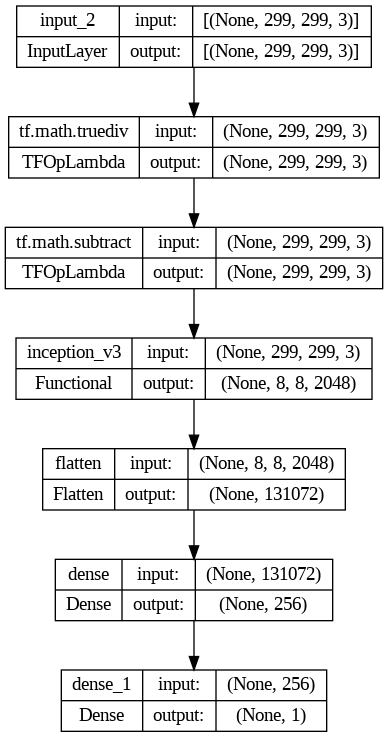

In [ ]:
# display model structure
plot_model(simple_model, 'inceptionV3_feature_extraction_simple_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_simple_model.png"))

# save image to drive
!cp -r './inceptionV3_feature_extraction_simple_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 19s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7909    0.7958    0.7933      2086
           1     0.7907    0.7856    0.7881      2048

    accuracy                         0.7908      4134
   macro avg     0.7908    0.7907    0.7907      4134
weighted avg     0.7908    0.7908    0.7908      4134



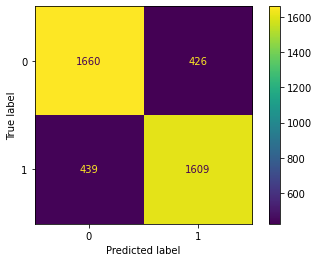

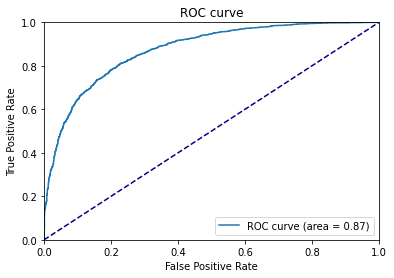

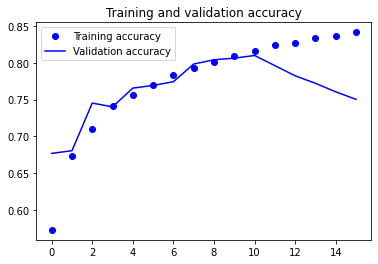

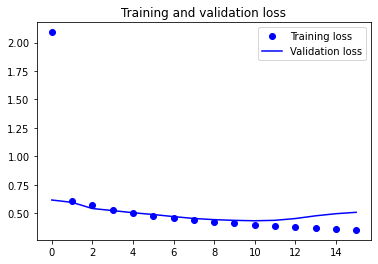

In [ ]:
# evaluate model
evaluate_model(simple_model)
show_train_val_performance(history)

### Droput model
As second experiment we add a **dropout layer** to the simple model in such a way to prevent overfitting.

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256,  "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
dropout_model = ks.Model(inputs = inputs, outputs = outputs, name='inceptionV3_feature_extraction_dropout')

In [ ]:
# compile the model
dropout_model = compile_model(dropout_model, 0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               335546

In [ ]:
# train the model
history = run_model(dropout_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.7785 - binary_accuracy: 0.5271
Epoch 1: val_loss improved from inf to 0.67095, saving model to ./models/model.h5
87/87 [==============================] - 116s 1s/step - loss: 1.7785 - binary_accuracy: 0.5271 - val_loss: 0.6709 - val_binary_accuracy: 0.6720
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6785 - binary_accuracy: 0.5705
Epoch 2: val_loss did not improve from 0.67095
87/87 [==============================] - 85s 974ms/step - loss: 0.6785 - binary_accuracy: 0.5705 - val_loss: 0.6743 - val_binary_accuracy: 0.6495
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6677 - binary_accuracy: 0.5841
Epoch 3: val_loss improved from 0.67095 to 0.64411, saving model to ./models/model.h5
87/87 [==============================] - 87s 997ms/step - loss: 0.6677 - binary_accuracy: 0.5841 - val_loss: 0.6441 - val_binary_accuracy: 0.7017
Epoch 4/100
87/87 [========================

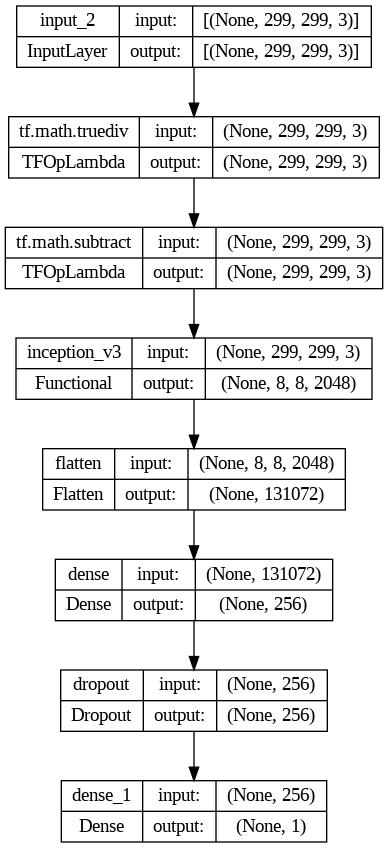

In [ ]:
# display model structure
plot_model(dropout_model, 'inceptionV3_feature_extraction_dropout.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_dropout.png"))

# save image to drive
!cp -r './inceptionV3_feature_extraction_dropout.png' IMAGES_DIR_PATH

17/17 [==============================] - 18s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7654    0.8365    0.7994      2086
           1     0.8161    0.7388    0.7755      2048

    accuracy                         0.7881      4134
   macro avg     0.7907    0.7876    0.7874      4134
weighted avg     0.7905    0.7881    0.7875      4134



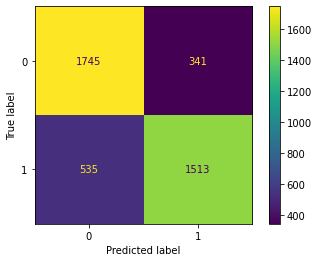

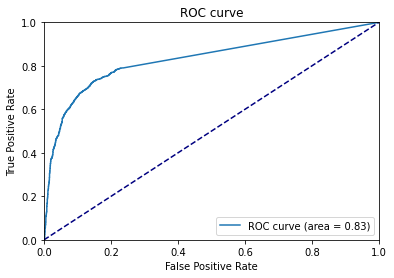

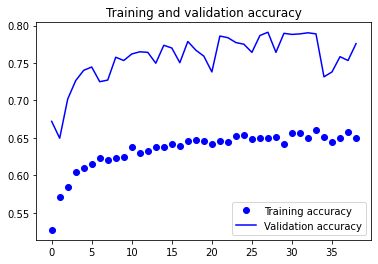

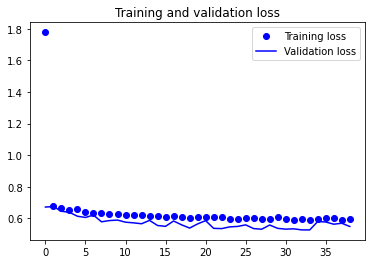

In [ ]:
# evaluate model
evaluate_model(dropout_model)
show_train_val_performance(history)

### Global average pooling model

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256,  "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
another_model = ks.Model(inputs = inputs, outputs = outputs, name = 'inceptionV3_feature_extraction_global_avg_model')

In [ ]:
# compile the model
another_model = compile_model(another_model, 0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
# train the model
history = run_model(another_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.6684 - binary_accuracy: 0.5982
Epoch 1: val_loss improved from inf to 0.63247, saving model to ./models/model.h5
87/87 [==============================] - 105s 965ms/step - loss: 0.6684 - binary_accuracy: 0.5982 - val_loss: 0.6325 - val_binary_accuracy: 0.6749
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6387 - binary_accuracy: 0.6412
Epoch 2: val_loss improved from 0.63247 to 0.61847, saving model to ./models/model.h5
87/87 [==============================] - 78s 899ms/step - loss: 0.6387 - binary_accuracy: 0.6412 - val_loss: 0.6185 - val_binary_accuracy: 0.6713
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6243 - binary_accuracy: 0.6573
Epoch 3: val_loss improved from 0.61847 to 0.60947, saving model to ./models/model.h5
87/87 [==============================] - 80s 914ms/step - loss: 0.6243 - binary_accuracy: 0.6573 - val_loss: 0.6095 - val_binary_accuracy: 0.6734
E

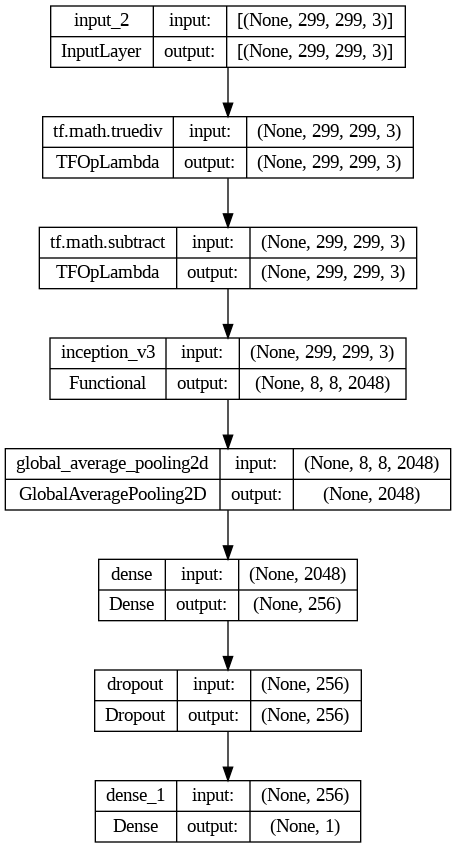

In [ ]:
# display model structure
plot_model(another_model, 'inceptionV3_feature_extraction_global_avg_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_global_avg_model.png"))

# save image to drive
!cp -r './inceptionV3_feature_extraction_global_avg_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 19s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7607    0.7953    0.7776      2086
           1     0.7814    0.7451    0.7628      2048

    accuracy                         0.7704      4134
   macro avg     0.7710    0.7702    0.7702      4134
weighted avg     0.7709    0.7704    0.7703      4134



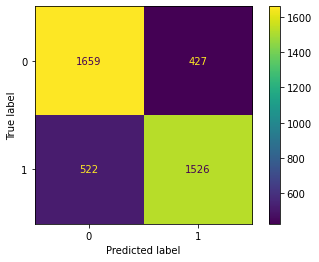

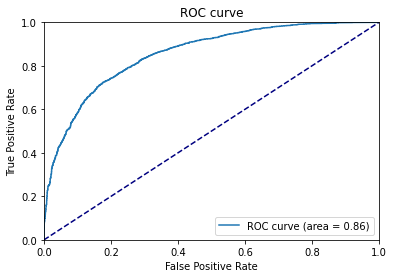

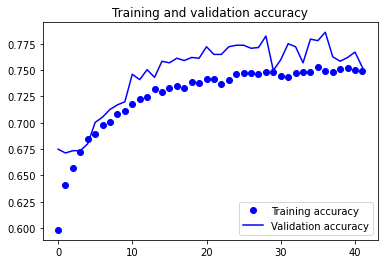

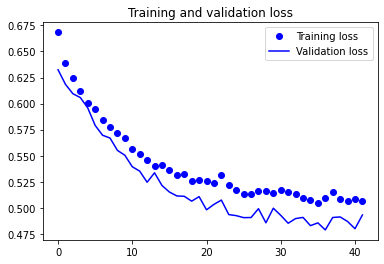

In [ ]:
# evaluate model
evaluate_model(another_model)
show_train_val_performance(history)

### Simplest model

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(64, "relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
simplest_model = ks.Model(inputs = inputs, outputs = outputs, name = 'inceptionV3_feature_extraction_simplest_model')

In [ ]:
# compile the model
simplest_model = compile_model(simplest_model, 0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                838867

In [ ]:
# train the model
history = run_model(simplest_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.1476 - binary_accuracy: 0.6017
Epoch 1: val_loss improved from inf to 0.56010, saving model to ./models/model.h5
87/87 [==============================] - 128s 1s/step - loss: 1.1476 - binary_accuracy: 0.6017 - val_loss: 0.5601 - val_binary_accuracy: 0.7235
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.5574 - binary_accuracy: 0.7128
Epoch 2: val_loss did not improve from 0.56010
87/87 [==============================] - 90s 1s/step - loss: 0.5574 - binary_accuracy: 0.7128 - val_loss: 0.6578 - val_binary_accuracy: 0.6118
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.5227 - binary_accuracy: 0.7384
Epoch 3: val_loss did not improve from 0.56010
87/87 [==============================] - 90s 1s/step - loss: 0.5227 - binary_accuracy: 0.7384 - val_loss: 0.5626 - val_binary_accuracy: 0.6981
Epoch 4/100
87/87 [==============================] - ETA: 0s - loss: 0.4993 - binary_acc

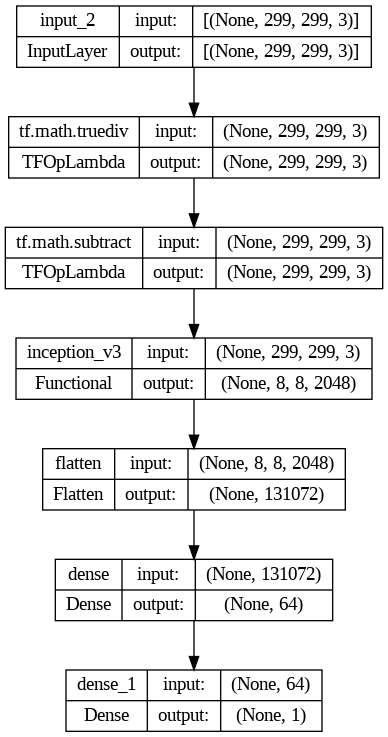

In [ ]:
# display model structure
plot_model(simplest_model, 'inceptionV3_feature_extraction_simplest_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_simplest_model.png"))

# save image to drive
!cp -r './inceptionV3_feature_extraction_simplest_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 20s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6600    0.9305    0.7722      2086
           1     0.8785    0.5117    0.6467      2048

    accuracy                         0.7230      4134
   macro avg     0.7692    0.7211    0.7095      4134
weighted avg     0.7682    0.7230    0.7100      4134



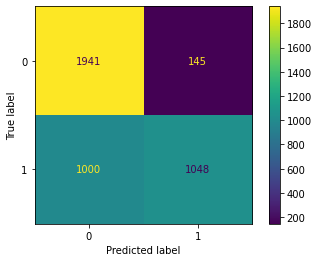

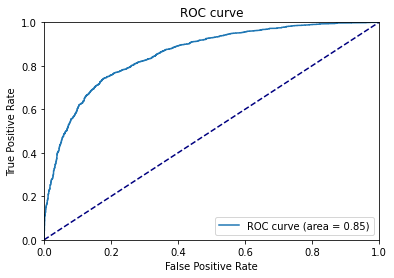

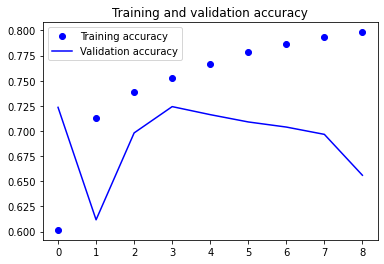

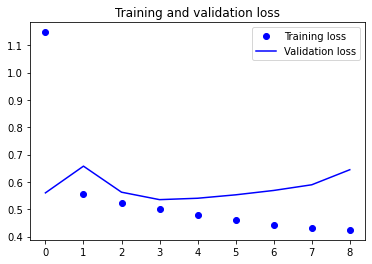

In [ ]:
# evaluate model
evaluate_model(simplest_model)
show_train_val_performance(history)

### Simplest model with dropout

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(64, "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
simplest_dropout_model = ks.Model(inputs = inputs, outputs = outputs, name = 'inceptionV3_feature_extraction_simplest_dropout_model')

In [ ]:
# compile the model
simplest_dropout_model = compile_model(simplest_dropout_model, 0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                8388

In [ ]:
# train the model
history = run_model(simplest_dropout_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.9233 - binary_accuracy: 0.5024
Epoch 1: val_loss improved from inf to 0.69314, saving model to ./models/model_1.h5
87/87 [==============================] - 97s 1s/step - loss: 0.9233 - binary_accuracy: 0.5024 - val_loss: 0.6931 - val_binary_accuracy: 0.5036
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4989
Epoch 2: val_loss did not improve from 0.69314
87/87 [==============================] - 90s 1s/step - loss: 0.6932 - binary_accuracy: 0.4989 - val_loss: 0.6931 - val_binary_accuracy: 0.5036
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4940
Epoch 3: val_loss did not improve from 0.69314
87/87 [==============================] - 90s 1s/step - loss: 0.6932 - binary_accuracy: 0.4940 - val_loss: 0.6931 - val_binary_accuracy: 0.4964
Epoch 4/100
87/87 [==============================] - ETA: 0s - loss: 0.6932 - binary_ac

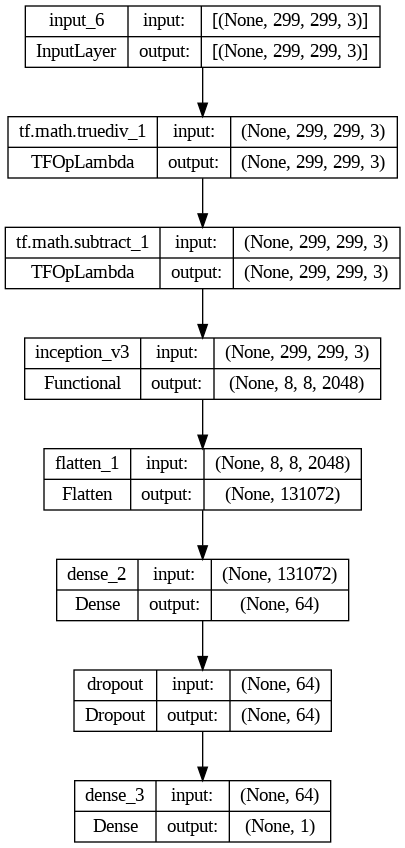

In [ ]:
# display model structure
plot_model(simplest_dropout_model, 'inceptionV3_feature_extraction_simplest_dropout_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_simplest_dropout_model.png"))


# save image to drive
!cp -r './inceptionV3_feature_extraction_simplest_dropout_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 17s 960ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.5046    1.0000    0.6707      2086
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.5046      4134
   macro avg     0.2523    0.5000    0.3354      4134
weighted avg     0.2546    0.5046    0.3385      4134



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


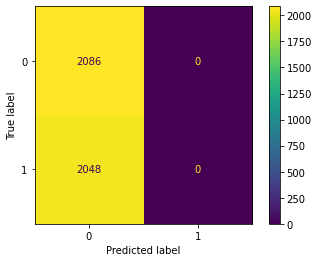

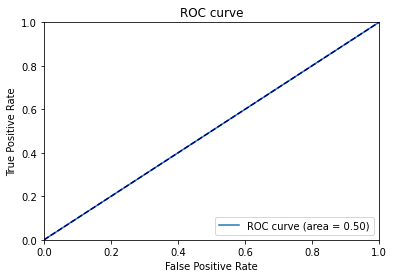

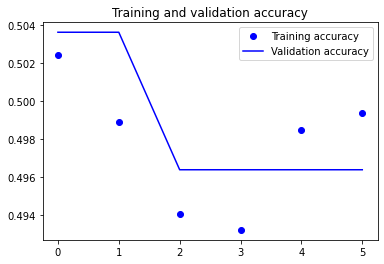

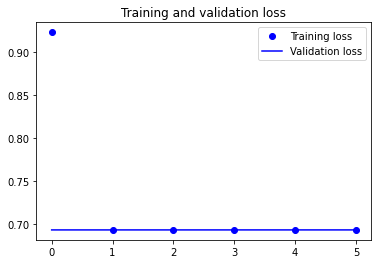

In [ ]:
# evaluate model
evaluate_model(simplest_dropout_model)
show_train_val_performance(history)

### Complex model


In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(299,299,3))
x = ks.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024,  "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
complex_model = ks.Model(inputs = inputs, outputs = outputs, name = 'inceptionV3_feature_extraction_complex_model')

In [ ]:
# compile the model
complex_model = compile_model(complex_model, 0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

In [ ]:
# train the model
history = run_model(complex_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.7021 - binary_accuracy: 0.5853
Epoch 1: val_loss improved from inf to 0.62992, saving model to ./models/model.h5
87/87 [==============================] - 106s 981ms/step - loss: 0.7021 - binary_accuracy: 0.5853 - val_loss: 0.6299 - val_binary_accuracy: 0.6684
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6346 - binary_accuracy: 0.6449
Epoch 2: val_loss improved from 0.62992 to 0.62023, saving model to ./models/model.h5
87/87 [==============================] - 79s 903ms/step - loss: 0.6346 - binary_accuracy: 0.6449 - val_loss: 0.6202 - val_binary_accuracy: 0.6669
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6225 - binary_accuracy: 0.6587
Epoch 3: val_loss improved from 0.62023 to 0.61560, saving model to ./models/model.h5
87/87 [==============================] - 81s 925ms/step - loss: 0.6225 - binary_accuracy: 0.6587 - val_loss: 0.6156 - val_binary_accuracy: 0.6618
E

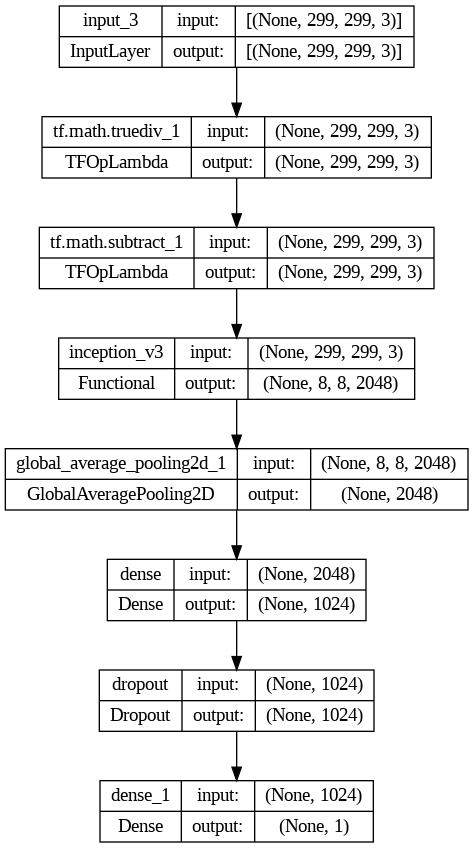

In [ ]:
# display model structure
plot_model(complex_model, 'inceptionV3_feature_extraction_complex_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_feature_extraction_complex_model.png"))

# save image to drive
!cp -r './inceptionV3_feature_extraction_complex_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 18s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7687    0.8063    0.7871      2086
           1     0.7924    0.7529    0.7722      2048

    accuracy                         0.7799      4134
   macro avg     0.7806    0.7796    0.7796      4134
weighted avg     0.7805    0.7799    0.7797      4134



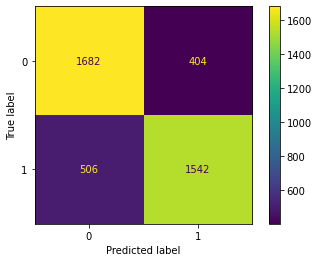

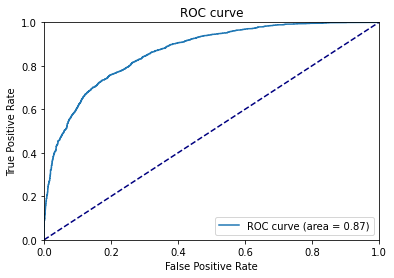

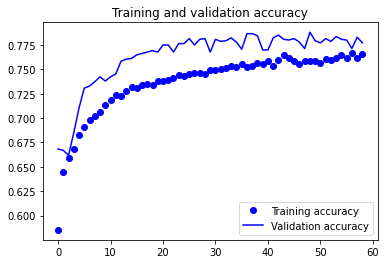

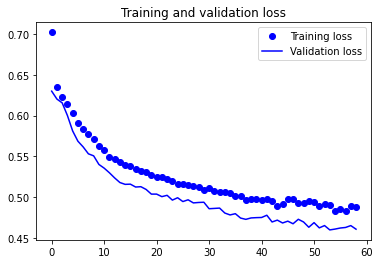

In [ ]:
# evaluate model
evaluate_model(complex_model)
show_train_val_performance(history)